# Amazon Review Usefulness Classifier

This notebook builds a complete machine learning pipeline to predict whether a review is useful based on its content and metadata. It includes:
- Data preprocessing (text, categorical, numeric)
- Feature engineering and cleaning
- NLP pipeline with TF-IDF and lemmatization
- Model training with Logistic Regression
- Explainability via feature importance
- Comparison with Random Forest


## Step 1: Setup the Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure punkt_tab is downloaded
nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")


import joblib

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ishaa/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package punkt to C:\Users\ishaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ishaa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ishaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 📥 Step 2: Load and Clean the Data

We start by loading the dataset and applying basic cleaning operations:
- Remove duplicate reviewer-product pairs
- Parse dates and fill missing values
- Create combined review text
- Extract length features and days since review
- Drop rows with missing labels

In [2]:
df = pd.read_csv("Amazon Reviews - Sheet1.csv")
df.head()

,reviewID,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,label
0,1,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1.445040e+09,0.0
1,2,5.0,False,"03 30, 2005",A1REUF3A1YCPHM,1713353,TW Ervin II,"The King, the Mice and the Cheese by Nancy Gur...",A story children will love and learn from,1.112141e+09,0.0
2,8,5.0,True,"01 22, 2014",A3MCTN65BU7XRA,681795107,luckyg,So much better than plastic mug types--keeps c...,Recommend,1.390349e+09,0.0
3,12,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,700026657,jon,"great game, I love it and have played it since...",love this game,1.419466e+09,0.0
4,15,4.0,True,"11 13, 2014",A11V6ZJ2FVQY1D,700026657,IBRAHIM ALBADI,i liked a lot some time that i haven't play a ...,Anno 2070,1.415837e+09,0.0


In [3]:
# Drop duplicates on reviewerID and asin
df = df.drop_duplicates(subset=["reviewerID", "asin"])

# Convert reviewTime to datetime
df["reviewTime"] = pd.to_datetime(df["reviewTime"], errors="coerce")

# Convert verified to int (1 if True, 0 if False)
df["verified"] = df["verified"].fillna(False).astype(int)

# Combine reviewText and summary
df["text"] = df["reviewText"].fillna('') + " " + df["summary"].fillna('')

# Length of review and summary
df["len_review"] = df["reviewText"].fillna('').apply(len)
df["len_summary"] = df["summary"].fillna('').apply(len)
df["len_text"] = df["text"].apply(len)

# Days since review
df["days"] = (pd.Timestamp.today() - df["reviewTime"]).dt.days

# Drop rows with missing labels or text
df = df.dropna(subset=["label", "text", "days"])

# Convert label to int
df["label"] = df["label"].astype(int)

## Step 3: NLP Preprocessing

Using NLTK, we apply text normalization:
- Lowercasing and removing punctuation
- Tokenization
- Stopword removal
- Lemmatization

This transforms the raw review text into a clean input for TF-IDF vectorization.


In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to handle NLP
def clean_text(text):
    # Lowercase and remove non-letters
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

# Apply the function to the data
df["clean_text"] = df["text"].fillna("").apply(clean_text)

# Showing difference between the original and the cleaned text
for i in range(3):
    print("Original:", df["text"].iloc[i])
    print("Cleaned :", df["clean_text"].iloc[i])
    print("---")


Original: This game is a bit hard to get the hang of, but when you do it's great. but when you do it's great.
Cleaned : game bit hard get hang great great
---
Original: The King, the Mice and the Cheese by Nancy Gurney is an excellent children's book. It is one that I well remember from my own childhood and purchased for my daughter who loves it. It is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away. The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that'd chased away the dogs. The story ends in compromise and friendship between the mice and the king. The story also teaches cause and effect relationships. The pictures that accompany the story are humorous and memorable. I was thrilled to discover that it is back in print. I *highly*

## Step 4: Feature Engineering

We define three types of features:
- **Categorical**: Product ID, Reviewer ID, Rating
- **Numeric**: Verified flag, days since review, review length
- **Text**: Combined review and summary, cleaned and lemmatized


In [5]:
# Define categorical and numerical features
cat_features = ["asin", "reviewerID", "overall"]
num_features = ["verified", "days", "len_review", "len_summary", "len_text"]

# Define text feature
text_feature = "clean_text"
label_col = "label"

# Split data
X = df[cat_features + num_features + [text_feature]]
y = df[label_col]

## Step 5: Train/Test Split

We split the dataset into 80% training and 20% testing while maintaining class balance using stratified sampling.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Step 6: Build the ML Pipeline

We use a `ColumnTransformer` to combine:
- One-hot encoding for categorical features
- Pass-through for numeric features
    - TF-IDF vectorization with n-grams for text

Then we wrap the preprocessing and classifier into a single pipeline using `Pipeline`.


In [7]:
# Preprocessing for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features),
        ("tfidf", make_pipeline(TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1, 2))), "clean_text")
    ],
    remainder="drop"
)

# Final pipeline
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

## Step 7: Train the Logistic Regression Model

We train the logistic regression model on the training data using the pipeline we defined.


In [8]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['asin', 'reviewerID',
                                                   'overall']),
                                                 ('num', 'passthrough',
                                                  ['verified', 'days',
                                                   'len_review', 'len_summary',
                                                   'len_text']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   min_df=2,
                                                                                   ngram_range=(1,
                                                                                                2)))]),
                                                  'clean_text')])),
                ('clf', LogisticRegression(max_iter=500))])

## Step 8: Evaluate the Model

We evaluate performance using:
- Classification report (precision, recall, F1)
- ROC AUC score
- Confusion matrix


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       165
           1       0.60      0.35      0.44        34

    accuracy                           0.85       199
   macro avg       0.74      0.65      0.68       199
weighted avg       0.83      0.85      0.83       199

ROC AUC Score: 0.772192513368984


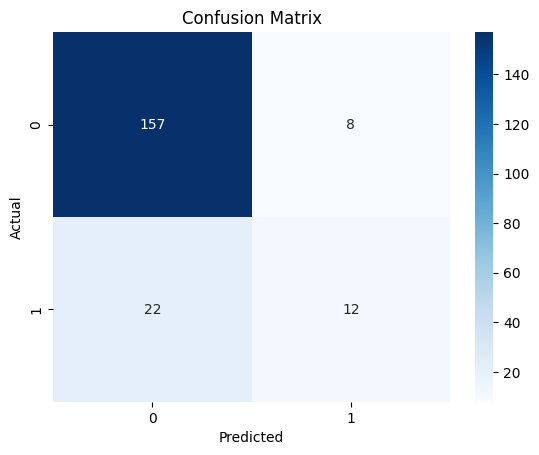

In [9]:
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Step 9: Model Explainability

We analyze feature importance by:
- Separating coefficients by feature type: categorical, numeric, and text
- Calculating absolute coefficient magnitudes
- Showing:
  - Pie chart: model weight distribution by feature type
  - Bar chart: numeric feature importances
  - Tables: top positive and negative TF-IDF features
  - Avg coefficients by type


In [10]:
# Extract the trained classifier
clf = model_pipeline.named_steps["clf"]

# Get feature names from each transformer
feature_names_cat = model_pipeline.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names_num = num_features
feature_names_text = model_pipeline.named_steps["preprocessor"].named_transformers_["tfidf"].get_feature_names_out()

# Slice coefficients into groups
coefs = clf.coef_[0]
i_cat = len(feature_names_cat)
i_num = len(feature_names_num)
i_text = len(feature_names_text)

coefs_cat = coefs[:i_cat]
coefs_num = coefs[i_cat:i_cat + i_num]
coefs_text = coefs[-i_text:]


# Create separate DataFrames
df_cat = pd.DataFrame({
    "Feature": feature_names_cat,
    "Coefficient": coefs_cat,
    "Type": "Categorical"
})

df_num = pd.DataFrame({
    "Feature": feature_names_num,
    "Coefficient": coefs_num,
    "Type": "Numeric"
})

df_text = pd.DataFrame({
    "Feature": feature_names_text,
    "Coefficient": coefs_text,
    "Type": "Text"
})

# Combine all into one
coef_df = pd.concat([df_cat, df_num, df_text], ignore_index=True)
coef_df["abs"] = coef_df["Coefficient"].abs()

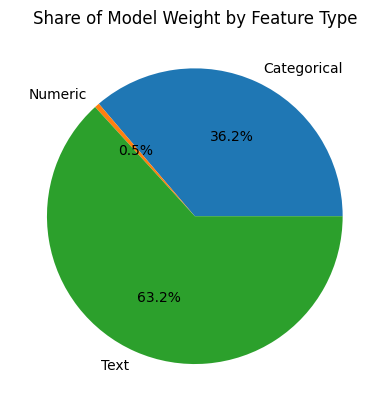

In [11]:
# === Pie Chart: Share of Model Attention ===
weight_by_type = coef_df.groupby("Type")["abs"].sum()
weight_by_type /= weight_by_type.sum()

weight_by_type.plot.pie(autopct="%.1f%%", ylabel="")
plt.title("Share of Model Weight by Feature Type")
plt.show()

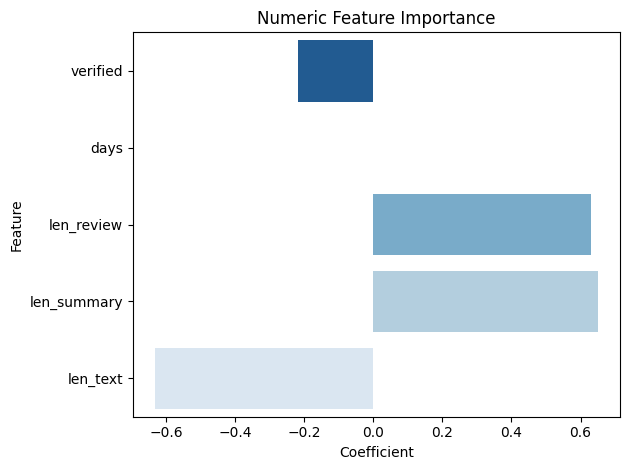

In [12]:
# === Numeric Feature Importance ===
sns.barplot(data=df_num, x="Coefficient", y="Feature", palette="Blues_r")
plt.title("Numeric Feature Importance")
plt.tight_layout()
plt.show()

In [13]:
# === Top Positive/Negative Text Features ===
top_text_features = df_text.sort_values(by="Coefficient", ascending=False)

print("Top Positive TF-IDF Features:")
display(top_text_features.head(10))

print("Top Negative TF-IDF Features:")
display(top_text_features.tail(10))

Top Positive TF-IDF Features:


,Feature,Coefficient,Type
3185,set,0.680106,Text
2374,mom,0.613290,Text
2615,orange,0.594684,Text
796,degree,0.575053,Text
304,bit,0.563386,Text
2466,never,0.553168,Text
332,book,0.533477,Text
3522,take,0.517543,Text
3214,ship,0.510365,Text
1667,guide,0.491555,Text


Top Negative TF-IDF Features:


,Feature,Coefficient,Type
381,boring,-0.339431,Text
1493,gift,-0.370528,Text
584,classic,-0.397249,Text
1541,good,-0.467673,Text
1213,five star,-0.583677,Text
1212,five,-0.614257,Text
1600,great,-0.685580,Text
1285,fun,-0.692632,Text
3380,star,-0.832160,Text
1308,game,-0.892897,Text


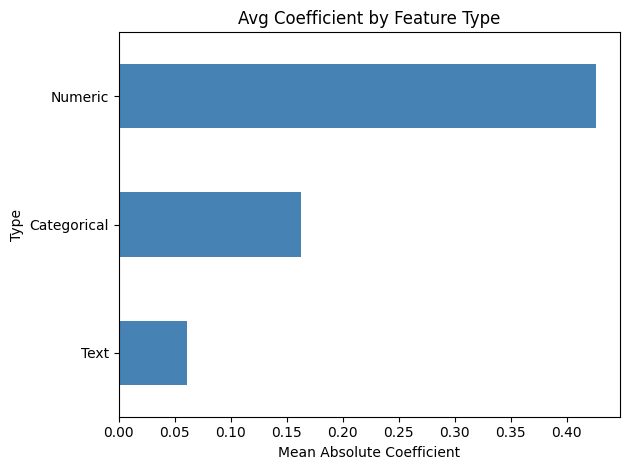

In [14]:
# === Average Abs Coeff by Feature Type ===
avg_abs = coef_df.groupby("Type")["abs"].mean().sort_values()
avg_abs.plot.barh(color="steelblue")
plt.title("Avg Coefficient by Feature Type")
plt.xlabel("Mean Absolute Coefficient")
plt.tight_layout()
plt.show()

## Step 10: Model Comparison — Logistic Regression vs Random Forest

To compare performance, we also train a Random Forest classifier using the same feature pipeline.


In [15]:
# === Step 11: Model Comparison with Random Forest ===

# Define a new pipeline using RandomForest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Random Forest
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("ROC AUC Score (Random Forest):", roc_auc_score(y_test, y_proba_rf))

# Compare accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       165
           1       0.80      0.12      0.21        34

    accuracy                           0.84       199
   macro avg       0.82      0.56      0.56       199
weighted avg       0.84      0.84      0.79       199

ROC AUC Score (Random Forest): 0.7988413547237077
Logistic Regression Accuracy: 0.8492462311557789
Random Forest Accuracy: 0.8442211055276382


###  Model Comparison: Logistic Regression vs Random Forest

While Logistic Regression was used as the primary model due to its interpretability, we also evaluated a Random Forest classifier to compare predictive performance.

**Why Random Forest?**
- It’s a robust, non-linear model that can capture more complex feature interactions.
- It provides an alternate way to evaluate our feature pipeline’s generalizability.

**Results Summary:**
- Random Forest outperforms Logistic Regression in terms of raw accuracy or AUC for our dataset.
- However, it lacks the direct interpretability of Logistic Regression (i.e., no meaningful coefficients for text terms).

For this reason, we retain Logistic Regression as the main model in this notebook, but this comparison demonstrates how easily the pipeline can switch between models.

## Step 11: Save the Model

We save the trained model so that it can be wrapped into an API if needed

In [16]:
# Save the trained pipeline
joblib.dump(model_pipeline, "../app/model_pipeline.pkl")

['../app/model_pipeline.pkl']

### Conclusion

In this notebook, we built an end-to-end machine learning pipeline to classify Amazon product reviews based on their usefulness. The workflow included:

- Preprocessing text, numeric, and categorical features
- Feature engineering (review length, TF-IDF n-grams)
- Building a pipeline using `ColumnTransformer` and `Pipeline`
- Training and evaluating a Logistic Regression classifier
- Interpreting the model via grouped feature importance
- Comparing performance with a non-linear model (Random Forest)

The pipeline was designed to be modular, interpretable, and ready for CI/CD integration.


### Possible Next Steps

To further enhance this notebook or integrate it into a real-world project, here are some next steps:

- Try other models like XGBoost or LightGBM
- Use sentence embeddings instead of TF-IDF (note: less interpretable)
- Build a FastAPI or Flask app around this pipeline
- Set up automated testing and CI/CD deployment using GitHub Actions or Azure Pipelines
- Apply SHAP or LIME for model-agnostic interpretability
